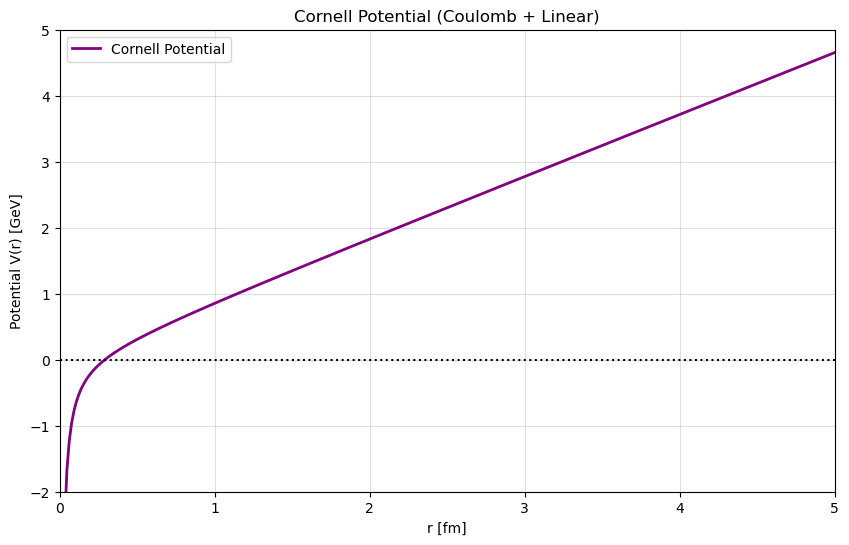

1s state: E = 0.3489 GeV, norm = 0.998746
Saved 1s data to quarkonia_results/charmonium_1s.dat
2s state: E = 0.9715 GeV, norm = 0.999201
Saved 2s data to quarkonia_results/charmonium_2s.dat
2p state: E = 1.3254 GeV, norm = 1.000000
Saved 2p data to quarkonia_results/charmonium_2p.dat
3s state: E = 1.4312 GeV, norm = 0.999328
Saved 3s data to quarkonia_results/charmonium_3s.dat
3p state: E = 1.7285 GeV, norm = 1.000000
Saved 3p data to quarkonia_results/charmonium_3p.dat
3d state: E = 1.9380 GeV, norm = 1.000000
Saved 3d data to quarkonia_results/charmonium_3d.dat


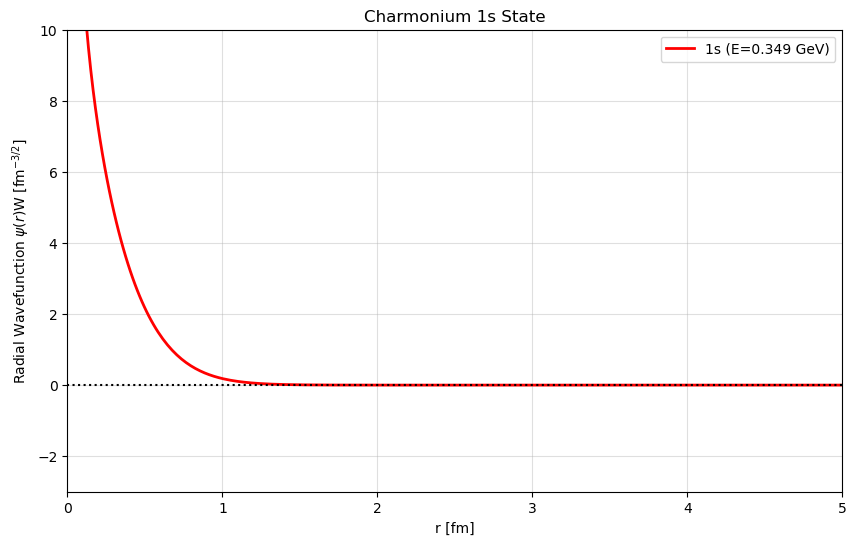

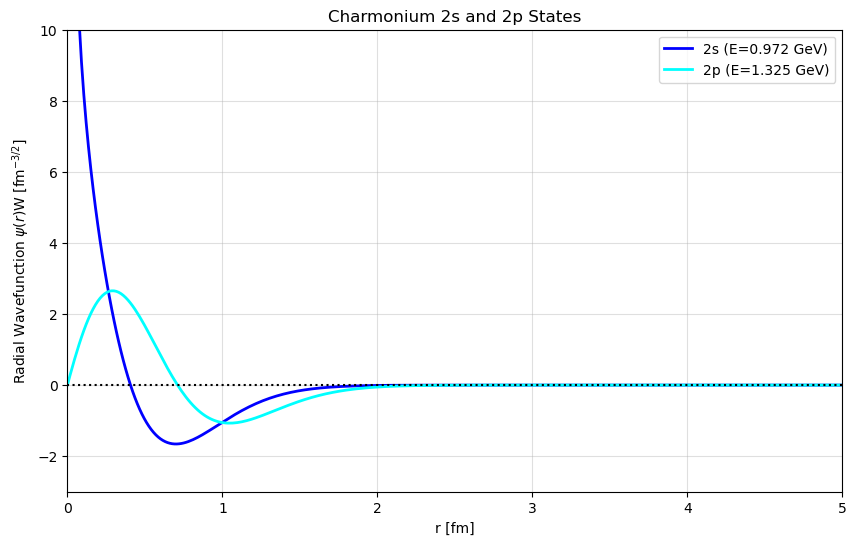

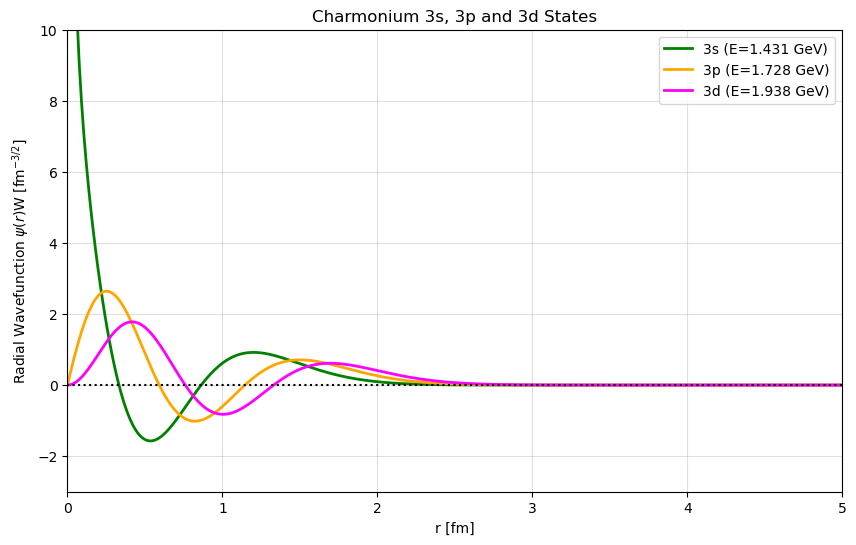

All results saved in directory: /Users/mohammadyousuf/Desktop/ML_QQ_codes/ML_code_QQ/quarkonia_results


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Constants
hbar = 0.19732  # GeV·fm
sigma = 0.184   # GeV^2
xmin, xmax = 0.001, 30.0  # Range in fm
interval = 2001  # Resolution

# Create output directory
output_dir = "quarkonia_results"
os.makedirs(output_dir, exist_ok=True)

# Charmonium parameters
mc = 1.35  # GeV (for bottomonium use mc = 4.7)
mcr = mc / 2.0  # Reduced mass
alpha_s = 0.3   # Strong coupling constant
cf = 4/3        # Casimir factor

# Schrodinger solver class (now including angular momentum)
class Schrodinger:
    def __init__(self, V_re_func, mass, hbar, xmin, xmax, ninterval):
        self.r = np.linspace(xmin, xmax, ninterval)
        self.dr = self.r[1] - self.r[0]
        self.mass = mass
        self.hbar = hbar
        self.V_func = V_re_func
        
    def solve_state(self, n, l=0):
        """Solve for a specific state with principal quantum number n and angular momentum l"""
        # Effective potential includes centrifugal term
        centrifugal = l*(l+1)*self.hbar**2/(2*self.mass*self.r**2)
        self.U = np.diag(self.V_func(self.r) + centrifugal, 0)
        self.Lap = self.laplacian(len(self.r))
        self.H = -self.hbar**2/(2.0*self.mass)*self.Lap + self.U
        
        # Solve
        w, v = np.linalg.eigh(self.H)
        # Phase correction
        for i in range(v.shape[1]):
            if v[1,i] < 0:
                v[:,i] *= -1
                
        # Return the nth state (0-based index)
        if n < len(w):
            return w[n], v[:,n]
        else:
            raise IndexError(f"State n={n} not found in solutions")

    def laplacian(self, N):
        return (-2*np.diag(np.ones(N)) + np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1))/(self.dr**2)

    def normalize_radial_wavefunction(self, R_r):
        integrand = np.abs(R_r)**2 * self.r**2
        norm = np.sqrt(np.sum(integrand) * self.dr)
        return R_r / norm

    def radial_wavefunction(self, u_n):
        R_r = np.where(self.r > 0, u_n/self.r, u_n[1]/self.r[1])
        return self.normalize_radial_wavefunction(R_r)

# Cornell Potential (Coulomb + linear)
def cornell_potential(r):
    r = np.where(r < 0.001, 0.001, r)  # Regularization at r=0
    hbar = 0.197  # GeV·fm
    s = r / hbar  # Convert to GeV^-1
    return -cf * alpha_s / s + sigma * s  # Coulomb + linear

# Initialize solver
sch = Schrodinger(cornell_potential, mass=mcr, hbar=hbar,
                xmin=xmin, xmax=xmax, ninterval=interval)

# Plot and save potential
potential_r = sch.r
potential_values = cornell_potential(potential_r)

plt.figure(figsize=(10, 6))
plt.plot(potential_r, potential_values, label='Cornell Potential', color='purple', linewidth=2)
plt.axhline(0, color='k', linestyle=':')
plt.xlabel(r"r [fm]")
plt.ylabel(r"Potential V(r) [GeV]")
plt.title("Cornell Potential (Coulomb + Linear)")
plt.grid(True, alpha=0.4)
plt.xlim(0, 5)
plt.ylim(-2, 5)
plt.legend()

potential_plot_filename = os.path.join(output_dir, "cornell_potential.png")
plt.savefig(potential_plot_filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Save potential data
potential_filename = os.path.join(output_dir, "cornell_potential.dat")
with open(potential_filename, 'w') as f:
    for r, v in zip(potential_r, potential_values):
        f.write(f"{{{r:.6f},{v:.6f}}}\n")

# Solve for states and organize plots
states_to_solve = [
    # (n, l, state_name, color)
    (0, 0, '1s', 'red'),
    (1, 0, '2s', 'blue'),
    (1, 1, '2p', 'cyan'),
    (2, 0, '3s', 'green'),
    (2, 1, '3p', 'orange'),
    (2, 2, '3d', 'magenta')
]

# Store all wavefunctions
wavefunctions = {}
for n, l, state_name, color in states_to_solve:
    try:
        E, u_n = sch.solve_state(n, l)
        R_q = sch.radial_wavefunction(u_n)
        wavefunctions[state_name] = (sch.r, R_q, color, E)
        
        # Save data for each state
        wavefunction_filename = os.path.join(output_dir, f"charmonium_{state_name}.dat")
        with open(wavefunction_filename, 'w') as f:
            for r, psi in zip(sch.r, R_q):
                f.write(f"{{{r:.6f},{psi:.6f}}}\n")
        
        # Check normalization
        norm = np.trapz(R_q**2 * sch.r**2, sch.r)
        print(f"{state_name} state: E = {E:.4f} GeV, norm = {norm:.6f}")
        print(f"Saved {state_name} data to {wavefunction_filename}")
        
    except IndexError as e:
        print(f"Failed to solve {state_name}: {str(e)}")

# Create grouped plots
def plot_group(states, title):
    plt.figure(figsize=(10, 6))
    for state_name in states:
        if state_name in wavefunctions:
            r, R_q, color, E = wavefunctions[state_name]
            plt.plot(r, R_q, label=f'{state_name} (E={E:.3f} GeV)', color=color, linewidth=2)
    
    plt.axhline(0, color='k', linestyle=':')
    plt.xlabel(r"r [fm]")
    plt.ylabel(r"Radial Wavefunction $\psi(r)$ [fm$^{-3/2}$]")
    plt.title(title)
    plt.grid(True, alpha=0.4)
    plt.xlim(0, 5)
    plt.ylim(-3,10)
    plt.legend()
    
    plot_filename = os.path.join(output_dir, f"charmonium_{'_'.join(states)}.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot groups
plot_group(['1s'], "Charmonium 1s State")
plot_group(['2s', '2p'], "Charmonium 2s and 2p States")
plot_group(['3s', '3p', '3d'], "Charmonium 3s, 3p and 3d States")

print(f"All results saved in directory: {os.path.abspath(output_dir)}")